In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Notebook to investigate the performance of spike interface in localizing neurons 

In [2]:
import MEArec as mr # what we will use to create a synthetic recording
import spikeinterface.full as si  # what we will use to sort the spikes

import warnings
from probeinterface.plotting import plot_probe
from matplotlib import cm
from probeinterface import read_prb

import time
import numpy as np

job_kwargs = {'n_jobs' : -1, 'chunk_memory' : '10M', 'verbose': True, 'progress_bar': True}

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


In [5]:
rec = mr.load_recordings('recordings.h5')
gt_positions = np.hstack((rec.template_locations[:, 1:3], rec.template_locations[:, 0][:, np.newaxis]))

from spikeinterface.sortingcomponents.benchmark.benchmark_peak_localization import BenchmarkPeakLocalization, plot_comparison_positions
recording, gt_sorting = si.read_mearec('recordings.h5')
recording_f = si.bandpass_filter(recording)
recording_f = si.common_reference(recording_f)
recording_f = si.zscore(recording_f)

In [6]:
#waveforms = si.extract_waveforms(recording_f, gt_sorting, mode='memory', sparse=True, method='radius', radius_um=50, **job_kwargs)
waveforms = si.extract_waveforms(recording_f, gt_sorting, mode='memory', **job_kwargs)

extract waveforms shared_memory with n_jobs = 20 and chunk_size = 9765


extract waveforms shared_memory:   0%|          | 0/33 [00:00<?, ?it/s]

In [10]:
job_kwargs = {'n_jobs' : -1, 'chunk_duration' : '1s', 'verbose': True, 'progress_bar': True}
positions_bis = si.compute_spike_locations(waveforms, method='center_of_mass', **job_kwargs)
positions = si.compute_spike_locations(waveforms, method='center_of_mass', **job_kwargs)

{'ms_before': 0.5, 'ms_after': 0.5, 'channel_from_template': True, 'method': 'center_of_mass'}
localize peaks using center_of_mass with n_jobs = 20 and chunk_size = 32000


localize peaks using center_of_mass:   0%|          | 0/10 [00:00<?, ?it/s]

{'ms_before': 0.5, 'ms_after': 0.5, 'channel_from_template': True, 'method': 'center_of_mass'}
localize peaks using center_of_mass with n_jobs = 20 and chunk_size = 32000


localize peaks using center_of_mass:   0%|          | 0/10 [00:00<?, ?it/s]

In [5]:
from spikeinterface.sortingcomponents.peak_pipeline import run_node_pipeline, ExtractDenseWaveforms, PeakRetriever
from spikeinterface.sortingcomponents.features_from_peaks import PeakToPeakFeature
from spikeinterface.sortingcomponents.waveforms.savgol_denoiser import SavGolDenoiser
from spikeinterface.postprocessing.template_tools import get_template_extremum_channel
max_inds = get_template_extremum_channel(waveforms, outputs='index')
peaks = gt_sorting.to_spike_vector(extremum_channel_inds=max_inds)
node0 = PeakRetriever(recording_f, peaks)
node1 = ExtractDenseWaveforms(
        recording, parents=[node0], ms_before=0.5, ms_after=0.5, return_output=False
    )
node2 = PeakToPeakFeature(recording_f, parents=[node0, node1], return_output=True)
s = run_node_pipeline(recording_f, [node0, node1, node2], job_kwargs)
gt_labels = gt_sorting.ids_to_indices(gt_sorting.get_all_spike_trains()[0][1])

peak_pipeline with n_jobs = 20 and chunk_size = 9765


peak_pipeline:   0%|          | 0/33 [00:00<?, ?it/s]

In [6]:
import pylab as plt
import scipy
#all_stds = []

#all_means = []

u = np.zeros(s.shape)
nb_ptps = 5

ordering = np.zeros(len(u), dtype=int)
print(ordering.shape)

count = 0
limits = []
for i in np.unique(gt_labels):
    mask = gt_labels == i
    #plt.plot(s[mask][:, idx].T, c='0.5', alpha=0.1)
    #plt.plot(m_ptps[idx], 'r')
    #plt.fill_between(np.arange(len(idx)), (m_ptps-s_ptps)[idx], (m_ptps+s_ptps)[idx], color='0.5', alpha=0.25)
    #plt.scatter(m_ptps, s_ptps)
    ordering[count:count+np.sum(mask)] = np.where(mask)[0]
    u[count:count+np.sum(mask)] = s[mask]
    count += np.sum(mask)
    limits += [count]
    #all_stds += [np.std(s[mask])]
    #all_means += [np.mean(s[mask])]
#plt.plot(all_stds)
#plt.plot(all_means)

(32044,)


-0.5 255.5 32043.5 -0.5


(10000.0, 13000.0)

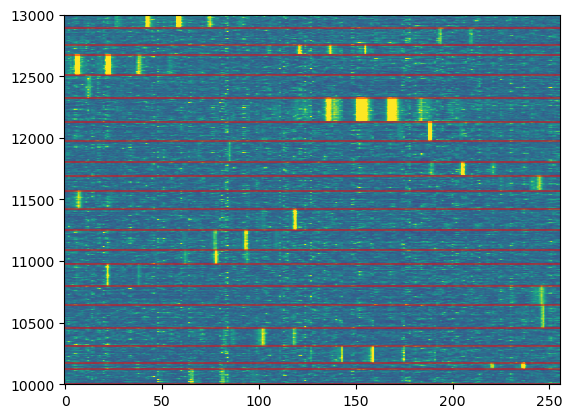

In [77]:
plt.imshow(s[ordering], aspect='auto', clim=(0, 10))
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
print(xmin, xmax, ymin, ymax)
for i in limits:
    plt.plot([xmin, xmax], [i, i], 'r', alpha=0.5)
plt.ylim(10000, 13000)

In [8]:
import sklearn
channel_positions = recording_f.get_channel_locations()
distances = sklearn.metrics.pairwise_distances(channel_positions, channel_positions)

[0.75749846 0.03040783 0.26823263]


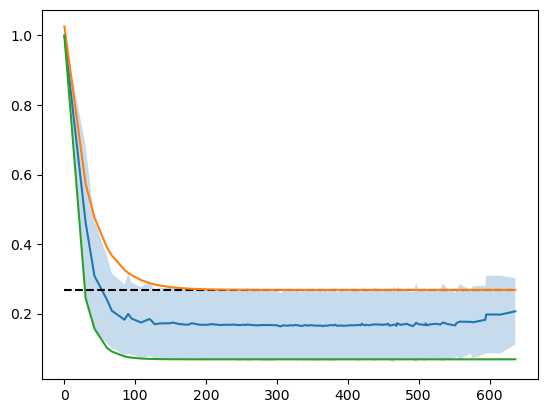

In [136]:
best_chans = np.argmax(s, axis=1)
import pylab as plt

x = distances[best_chans].flatten()
s_bis = s/(s.max(1)[:, np.newaxis])
y = s_bis.flatten()

d_values = np.unique(x)
means = np.zeros(len(d_values))
stds = np.zeros(len(d_values))
for count, d in enumerate(d_values):
    mask = x == d
    means[count] = y[mask].mean()
    stds[count] = y[mask].std()

plt.plot(d_values, means)
plt.fill_between(d_values, means - stds, means + stds, alpha=0.25)

from scipy.optimize import curve_fit
def ptp_decay(x, a, b, c):
    return a*np.exp(-b*x) + c

popt_max, pcov = curve_fit(ptp_decay, d_values, means + stds, [0.8, 0.1, 0.2])
popt_min, pcov = curve_fit(ptp_decay, d_values, means - stds, [0.8, 0.1, 0.2])

print(popt_max)

plt.plot([d_values[0], d_values[-1]], [popt_max[2], popt_max[2]], 'k--')
plt.plot(d_values, ptp_decay(d_values, *popt_max))
plt.plot(d_values, ptp_decay(d_values, *popt_min))

In [183]:
u = s.copy()
mask_min = s_bis < ptp_decay(distances[best_chans], *popt_max)
mask_max = s_bis > ptp_decay(distances[best_chans], *popt_min)

d_min = (distances[best_chans] > 10)

u[mask_min * mask_max * d_min] = 0

#thresholds = np.percentile(u, 9, axis=1)
#u[ u < thresholds[:, np.newaxis]] = 0
print(u.mean(), s.mean())


1.0254086 4.044577


-0.5 255.5 32043.5 -0.5


(10000.0, 13000.0)

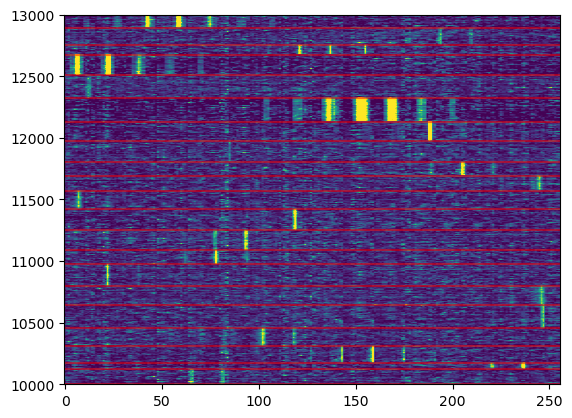

In [182]:
plt.imshow(u[ordering], aspect='auto', clim=(0, 10))
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
print(xmin, xmax, ymin, ymax)
for i in limits:
    plt.plot([xmin, xmax], [i, i], 'r', alpha=0.5)
plt.ylim(10000, 13000)

In [ ]:
import hdbscan
res = hdbscan.hdbscan(u)

In [23]:
import sklearn.metrics
tdist = sklearn.metrics.pairwise.cosine_similarity(u, u)

In [169]:
channel_positions = recording.get_channel_locations()
nb_features = 10
max_ptps = np.zeros((len(u), nb_features))
max_channels = np.zeros((len(u), nb_features), dtype=int)
com_positions = np.zeros((len(u), 2))

for i in range(len(u)):
    #max_channels[i] = np.argsort(u[i])[::-1][:nb_features]
    #max_ptps[i] = np.sort(u[i])[::-1][:nb_features]
    #com_positions[i] = np.dot(max_ptps[i], channel_positions[max_channels[0]])/max_ptps[i].sum()
    com_positions[i] = np.dot(u[i], channel_positions)/u[i].sum()

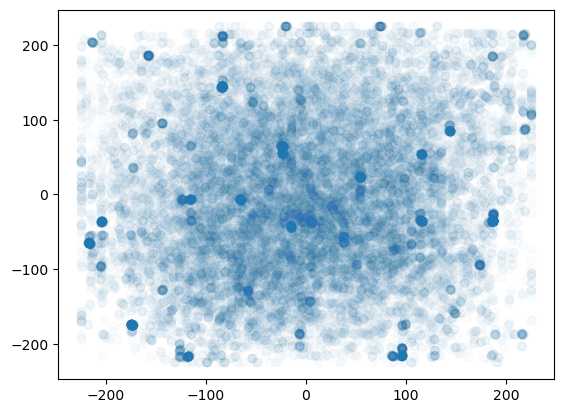

In [170]:
plt.scatter(com_positions[:, 0], com_positions[:, 1], alpha=0.02)

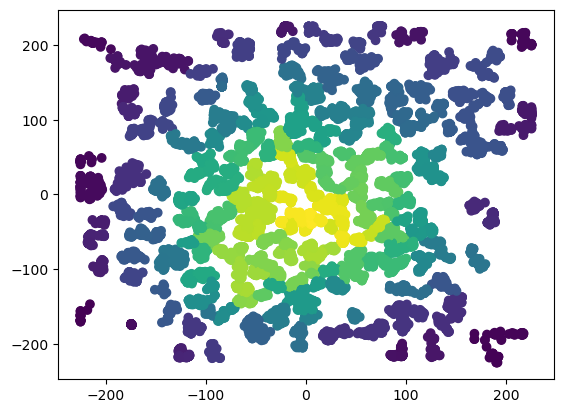

In [171]:
import hdbscan, os
hdbscan_kwargs = {
    "min_cluster_size": 20,
    "allow_single_cluster": True,
    "core_dist_n_jobs": os.cpu_count(),
    "cluster_selection_method": "leaf",
}
res = hdbscan.hdbscan(com_positions, **hdbscan_kwargs)

mask = res[0] > -1
plt.scatter(com_positions[mask, 0], com_positions[mask, 1], c=res[0][mask])

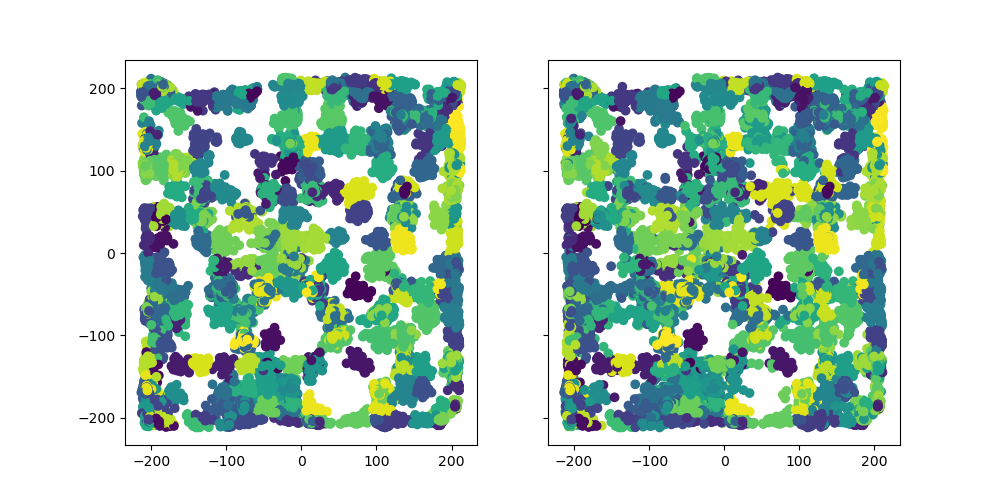

In [8]:
%matplotlib widget
import pylab as plt
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(10, 5))
unit_ids = waveforms.sorting.get_all_spike_trains()[0][1]
unit_inds = waveforms.sorting.ids_to_indices(unit_ids) 
axes[0].scatter(positions['x'], positions['y'], c=unit_inds)
axes[1].scatter(positions_bis['x'], positions_bis['y'], c=unit_inds)

In [9]:
dist = np.sqrt((positions['x'] - positions_bis['x'])**2 + (positions['y'] - positions_bis['y'])**2)
np.nanstd(dist)

7.146126238753393

In [16]:
import scipy
w = waveforms.get_waveforms('#10')
fs = waveforms.recording.get_sampling_frequency()
w2 = scipy.signal.savgol_filter(w, int(0.25*fs/1000), 3, axis=1)
print(w.shape)

(68, 224, 9)


In [6]:
np.linalg.norm(w-w2, axis=(1, 2))

array([69.85094 , 68.74674 , 67.63764 , 66.69042 , 69.7311  , 70.50288 ,
       72.53229 , 71.36188 , 68.8595  , 67.877045, 66.50863 , 70.2765  ,
       68.719505, 69.65815 , 71.07404 , 68.365486, 68.52904 , 69.473366,
       72.757355, 68.97075 , 70.31232 , 70.098946, 70.21189 , 69.31838 ,
       68.91188 , 68.75672 , 67.606834, 69.85073 , 69.17544 , 69.38221 ,
       69.181435, 70.05139 , 67.80081 , 70.29649 , 71.49945 , 70.62954 ,
       71.54097 , 67.84185 , 68.864716, 67.70712 , 72.54192 , 67.276825,
       69.88731 , 69.2459  , 70.783424, 69.61053 , 67.73731 , 70.02965 ,
       70.216194, 67.81173 , 69.150925, 71.845024, 69.72394 , 69.41973 ,
       68.53605 , 69.15343 , 68.32637 , 71.59423 , 68.52517 , 69.08869 ,
       68.512825, 69.47929 , 71.04668 , 65.2895  , 70.79876 , 70.61272 ,
       67.768974, 71.971306], dtype=float32)

[ 1.00383723e+00  5.53901891e+00  3.06945144e+00 -3.90953090e-03]


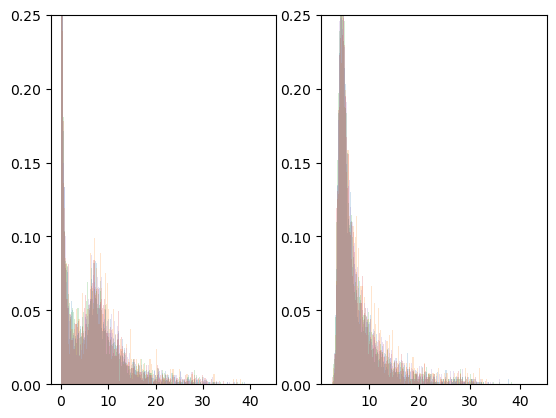

In [113]:
import pylab as plt
import scipy

fig, axes = plt.subplots(ncols=2)

x = np.random.randn(1000, waveforms.nsamples, waveforms.get_num_channels())
ptps = np.ptp(x, axis=1)
a, b = np.histogram(ptps.flatten(), np.linspace(0, 100, 1000))
ydata = np.cumsum(a)/a.sum()
xdata = b[1:]


from scipy.optimize import curve_fit
def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)

p0 = [max(ydata), np.median(xdata),1,min(ydata)] # this is an mandatory initial guess
popt, pcov = curve_fit(sigmoid, xdata, ydata, p0)
print(popt)

for unit_id in waveforms.sorting.unit_ids[:5]:
    w = waveforms.get_waveforms(unit_id)
    #fs = waveforms.recording.get_sampling_frequency()
    #w2 = scipy.signal.savgol_filter(w, int(fs/1000), 3, axis=1)
    ptps = np.ptp(w, axis=1)
    gated_ptps = sigmoid(ptps, *popt) * ptps
    axes[0].hist(gated_ptps.flatten(), 1000, alpha=0.2, density=True)
    axes[1].hist(ptps.flatten(), 1000, alpha=0.2, density=True)
axes[0].set_ylim(0, 0.25)
axes[1].set_ylim(0, 0.25)

plt.show()

In [104]:
sigmoid(ptps, *popt).shape

(60, 256)

In [63]:
si.get_noise_levels(recording_f)

array([0.99999994, 1.        , 1.        , 1.        , 1.0000001 ,
       1.        , 1.        , 1.0000001 , 1.        , 1.        ,
       1.        , 1.        , 0.99999994, 1.        , 0.99999994,
       1.        , 1.        , 1.        , 0.99999994, 1.        ,
       1.        , 1.        , 1.0000001 , 1.0000001 , 1.        ,
       0.9999998 , 1.        , 1.        , 0.99999994, 0.99999994,
       1.        , 1.0000001 , 1.        , 1.0000001 , 1.        ,
       1.        , 1.        , 1.        , 0.99999994, 1.        ,
       1.        , 1.        , 1.0000001 , 0.99999994, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.0000001 , 0.9999998 , 1.        , 1.        ,
       1.        , 0.99999994, 1.0000001 , 1.        , 1.        ,
       1.0000001 , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.0000001 , 1.        , 1.        ,
       1.        , 1.0000001 , 1.        , 1.        , 1.00000

In [6]:
ptps = gt_templates.ptp(axis=1)
energies = np.linalg.norm(gt_templates, axis=1)

In [49]:
projections = np.random.randn(300, 10)
projections -= projections.mean(0)
projections.std(0)

array([0.97009773, 0.99892706, 0.93107853, 1.00030844, 1.01989443,
       1.02127308, 1.04257292, 1.00657318, 0.9630176 , 1.05142947])

In [7]:
from spikeinterface.postprocessing.unit_localization import get_grid_convolution_templates_and_weights
templates_positions, weights, nearest_template_mask = get_grid_convolution_templates_and_weights(recording_f.get_channel_locations(), mode='3d')

In [19]:
best_templates = np.array([2339, 2117, 2451])
templates_positions[best_templates]
for i in templates_positions[best_templates]:
    print(i)

[-250. -270.  100.]
[ 250. -275.   90.]
[-220. -270.   60.]


In [24]:
mask = (templates_positions[:, 0] == -250)*(templates_positions[:, 1] == -270)
weights[0, :, mask].shape

(20, 256)

In [50]:
import sklearn
contact_locations = recording_f.get_channel_locations()
contact_locations = np.hstack((contact_locations, np.zeros((len(contact_locations), 1))))
dist = sklearn.metrics.pairwise_distances(contact_locations, templates_positions)

In [42]:
mask = templates_positions[:, 2] > 5

In [47]:
dist[:, mask].shape

(256, 110889)

/tmp/ipykernel_95713/3386211678.py:5: RuntimeWarning: divide by zero encountered in divide
  plt.plot(xaxis, 1/(xaxis), 'r')
/tmp/ipykernel_95713/3386211678.py:6: RuntimeWarning: divide by zero encountered in divide
  plt.plot(xaxis, 1/(xaxis**2), 'r')


(0.0, 0.025)

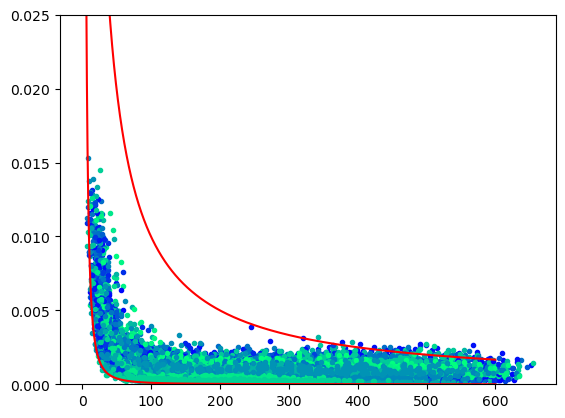

In [192]:
cmap = plt.get_cmap('winter', len(gt_templates))
idx = np.argsort(np.abs(positions[:, 2]))
for i in range(len(gt_templates)):
    plt.plot(dist[i], energies[i]/(energies[i]**2).sum(), '.', c=cmap(idx[i]))
plt.plot(xaxis, 1/(xaxis), 'r')
plt.plot(xaxis, 1/(xaxis**2), 'r')
plt.ylim(0, 0.025)

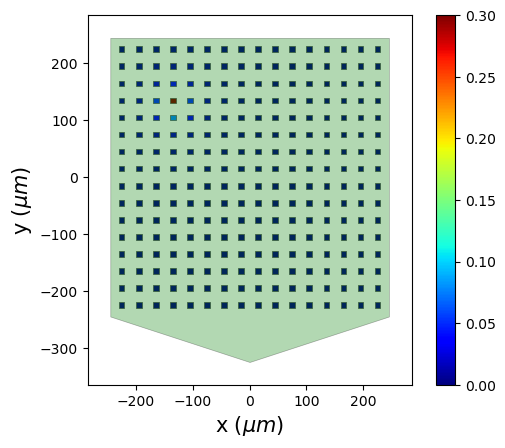

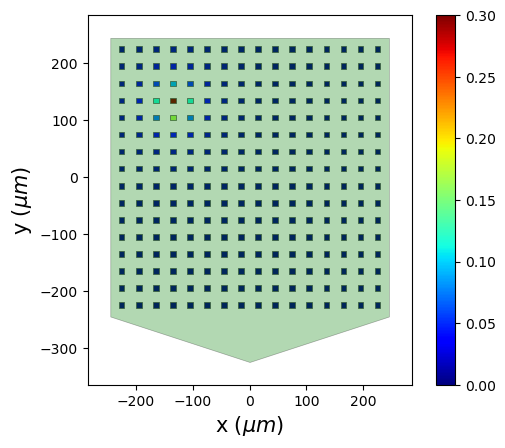

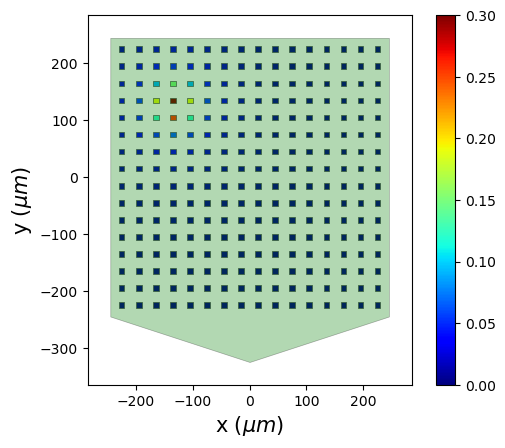

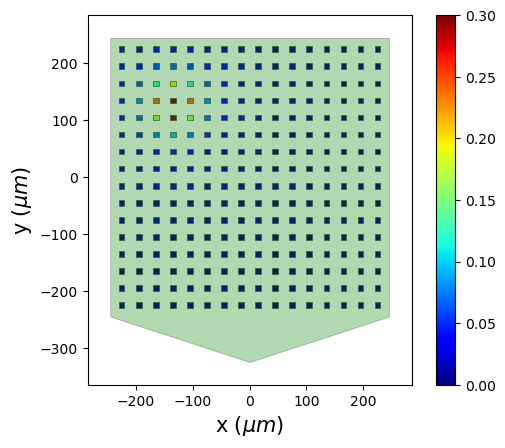

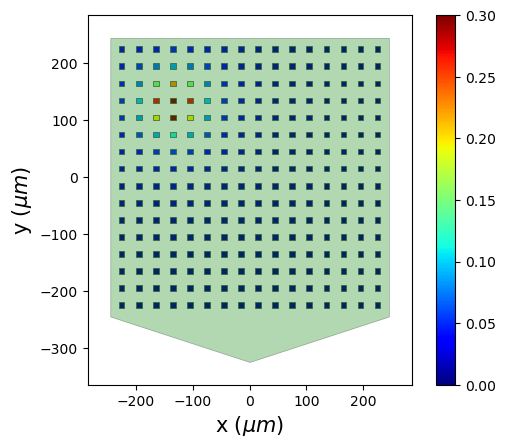

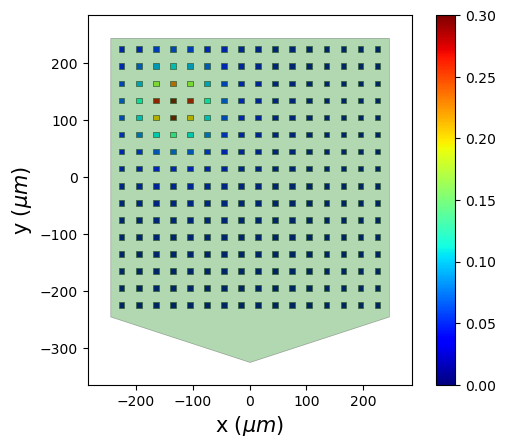

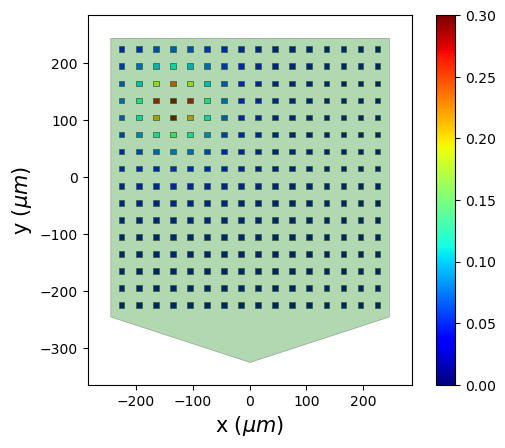

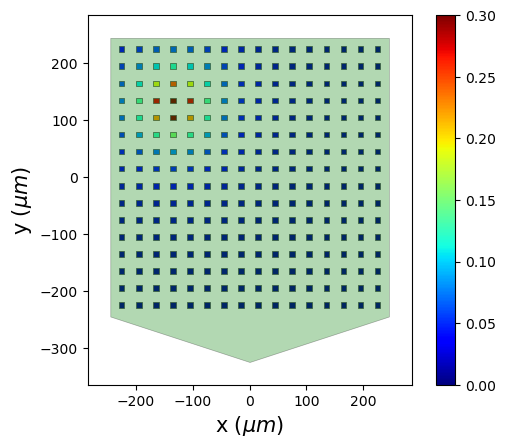

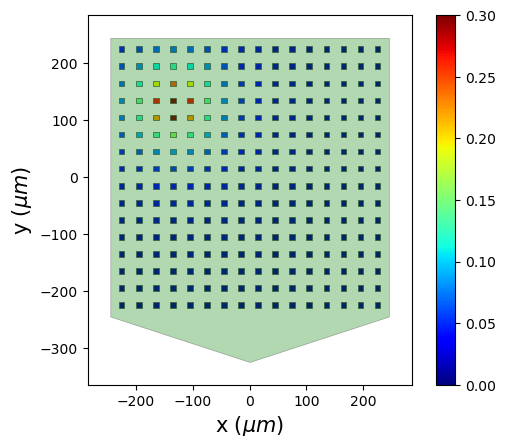

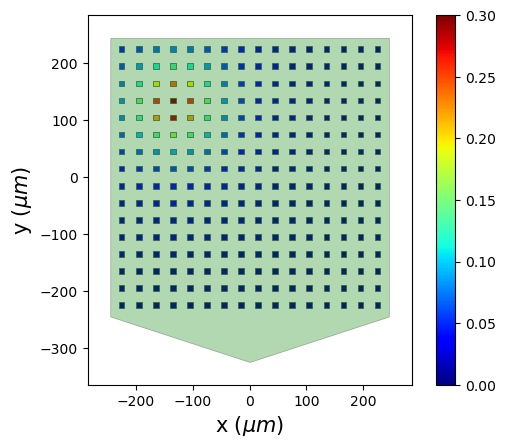

In [195]:
idx = np.argsort(np.abs(positions[:, 2]))

temp_id = 50
best_channel = np.argmin(gt_templates[temp_id], axis=1)

templates_positions, weights, nearest_template_mask = \
        get_grid_convolution_templates_and_weights(recording_f.get_channel_locations(), depth_um=50)

ax.scatter([positions[temp_id, 0]], [positions[temp_id, 1]], s=50, c='r')

diff = np.linalg.norm(templates_positions[:,:2] - positions[temp_id,:2], axis=1)
best_templates = np.argsort(diff)

best_templates = best_templates[:10]
order = np.argsort(templates_positions[best_templates, 2])

for best_template in best_templates[order]:

    fig, ax = plt.subplots()
    v = weights[0, :, best_template]
    poly, poly_contour = plot_probe(recording.get_probe(), contacts_values=v,
            cmap='jet', ax=ax, contacts_kargs={'alpha' : 1},  title=False)
    poly.set_clim(0, 0.3)
    fig.colorbar(poly)


(12321, 2)


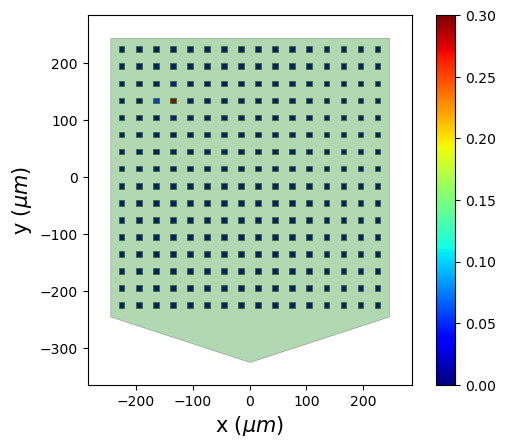

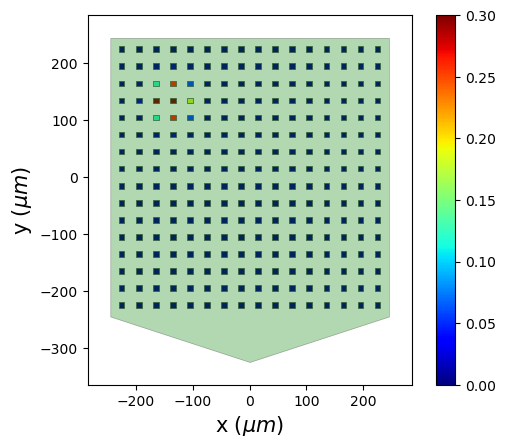

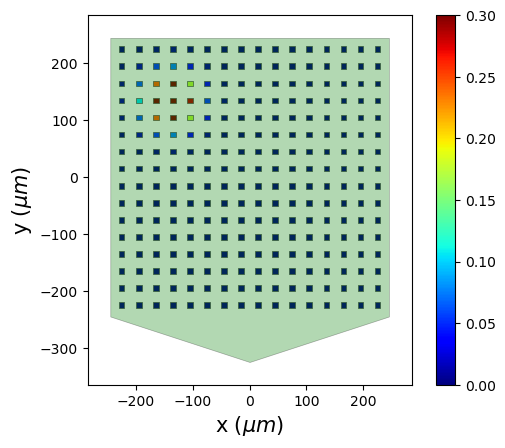

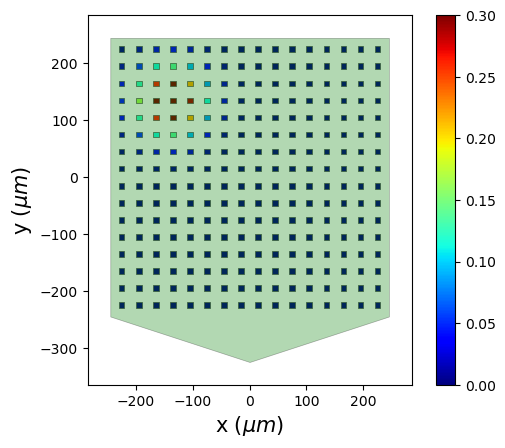

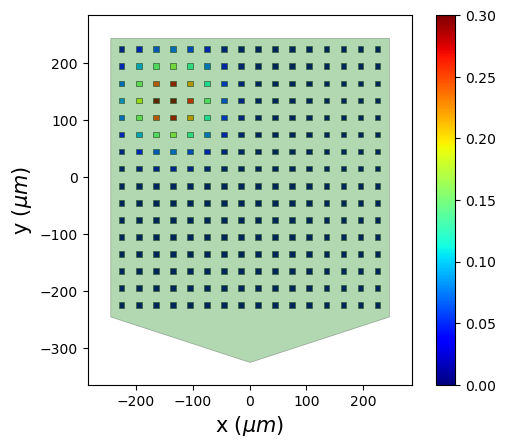

In [165]:
idx = np.argsort(np.abs(positions[:, 2]))

temp_id = 50
best_channel = np.argmin(gt_templates[temp_id], axis=1)

templates_positions, weights, nearest_template_mask = \
        get_grid_convolution_templates_and_weights(recording_f.get_channel_locations())

ax.scatter([positions[temp_id, 0]], [positions[temp_id, 1]], s=50, c='r')

print(templates_positions.shape)
diff = np.linalg.norm(templates_positions[:,:2] - positions[temp_id,:2], axis=1)
best_templates = np.argmin(diff)

for count in range(len(weights)):

    fig, ax = plt.subplots()
    v = weights[count, :, best_template]
    poly, poly_contour = plot_probe(recording.get_probe(), contacts_values=v,
            cmap='jet', ax=ax, contacts_kargs={'alpha' : 1},  title=False)
    poly.set_clim(0, 0.3)
    fig.colorbar(poly)


In [151]:
print(weights.shape)

(1, 256, 123210)


In [6]:
positions = si.compute_spike_locations(waveforms, method='grid_convolution')

peak_pipeline:   0%|          | 0/10 [00:00<?, ?it/s]

localize peaks using grid_convolution:   0%|          | 0/10 [00:00<?, ?it/s]

(array([0.06713889, 0.02685556, 0.        , 0.02685556, 0.04028333,
        0.02685556, 0.04028333, 0.05371111, 0.02685556, 0.04028333,
        0.05371111, 0.04028333, 0.05371111, 0.        , 0.05371111,
        0.04028333, 0.05371111, 0.02685556, 0.06713889, 0.01342778,
        0.02685556, 0.02685556, 0.05371111, 0.04028333, 0.02685556,
        0.04028333, 0.02685556, 0.01342778, 0.06713889, 0.04028333,
        0.04028333, 0.05371111, 0.01342778, 0.04028333, 0.04028333,
        0.01342778, 0.01342778, 0.01342778, 0.04028333, 0.05371111,
        0.04028333, 0.02685556, 0.04028333, 0.08056667, 0.05371111,
        0.05371111, 0.01342778, 0.04028333, 0.02685556, 0.01342778,
        0.02685556, 0.01342778, 0.        , 0.01342778, 0.04028333,
        0.05371111, 0.04028333, 0.02685556, 0.05371111, 0.02685556,
        0.04028333, 0.01342778, 0.06713889, 0.        , 0.02685556,
        0.02685556, 0.02685556, 0.05371111, 0.04028333, 0.05371111,
        0.01342778, 0.        , 0.02685556, 0.02

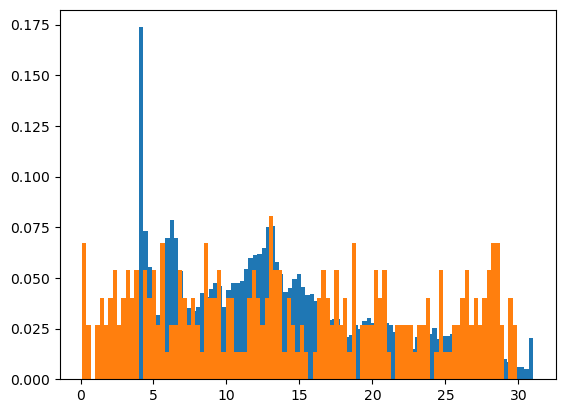

In [7]:
import pylab as plt
plt.hist(positions['z'], 100, density=True)
plt.hist(np.abs(gt_positions[:, 2]), 100, density=True)

In [8]:
benchmarks = []
waveforms = None
for method in ['grid_convolution', 'monopolar_triangulation', 'center_of_mass']:
    if method == 'center_of_mass':
        for feature in ['ptp']:
            title = f'CoM ({feature})'
            params = {'feature' : feature}
            bench = BenchmarkPeakLocalization(recording_f, gt_sorting, gt_positions, job_kwargs=job_kwargs, title=title)
            if waveforms is not None:
                bench.waveforms = waveforms
            bench.run(method, params)
            waveforms = bench.waveforms
            benchmarks.append(bench)
    elif method == 'monopolar_triangulation':
        for feature in ['ptp']:
            title = f'Monopolar ({feature})'
            params = {'enforce_decrease': True, 'feature' : feature}
            bench = BenchmarkPeakLocalization(recording_f, gt_sorting, gt_positions, job_kwargs=job_kwargs, title=title)
            if waveforms is not None:
                bench.waveforms = waveforms
            bench.run(method, params)
            waveforms = bench.waveforms
            benchmarks.append(bench)
    elif method == 'grid_convolution':
        title = 'Grid'
        params = {}
        bench = BenchmarkPeakLocalization(recording_f, gt_sorting, gt_positions, job_kwargs=job_kwargs, title=title)
        if waveforms is not None:
            bench.waveforms = waveforms
        bench.run(method, params)
        waveforms = bench.waveforms
        benchmarks.append(bench)
    
    

extract waveforms memmap with n_jobs = 20 and chunk_size = 9765


extract waveforms memmap:   0%|          | 0/33 [00:00<?, ?it/s]

peak_pipeline with n_jobs = 20 and chunk_size = 9765


peak_pipeline:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using grid_convolution with n_jobs = 20 and chunk_size = 9765


localize peaks using grid_convolution:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation with n_jobs = 20 and chunk_size = 9765


localize peaks using monopolar_triangulation:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using center_of_mass with n_jobs = 20 and chunk_size = 9765


localize peaks using center_of_mass:   0%|          | 0/33 [00:00<?, ?it/s]

In [5]:
benchmarks[0].

In [9]:
colors = {}

import matplotlib as mpl

cmap = mpl.cm.tab20c
norm = mpl.colors.Normalize(vmin=0, vmax=1)



for value, bench in zip([0,0.05,0.1,0.4,0.45,0.5,0.8], benchmarks):    
    colors[bench.title] = mpl.cm.ScalarMappable(norm=norm, cmap=cmap).to_rgba(value)
    
plot_comparison_positions(benchmarks, colors=colors)
import pylab as plt
plt.savefig('comparison.pdf')

TypeError: plot_comparison_positions() got an unexpected keyword argument 'colors'

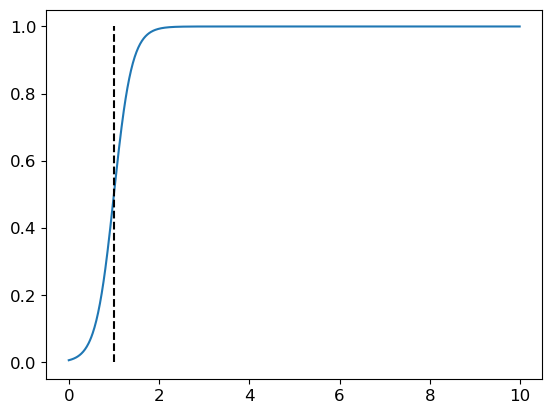

In [32]:
import pylab as plt
xaxis = np.arange(0, 10, 0.01)
from scipy.special import expit, logit
plt.plot(xaxis, expit(5*(xaxis - 1)))
plt.plot([1, 1], [0, 1], 'k--')

In [15]:
?expit

ZScoreRecording: 256 channels - 32.0kHz - 1 segments - 320,000 samples - 10.00s - float32 dtype 
                 312.50 MiB
extract waveforms shared_memory with n_jobs = 72 and chunk_size = 9765


extract waveforms shared_memory:   0%|          | 0/33 [00:00<?, ?it/s]

extract waveforms shared_memory with n_jobs = 72 and chunk_size = 9765


extract waveforms shared_memory:   0%|          | 0/33 [00:00<?, ?it/s]

extract waveforms shared_memory with n_jobs = 72 and chunk_size = 9765


extract waveforms shared_memory:   0%|          | 0/33 [00:00<?, ?it/s]

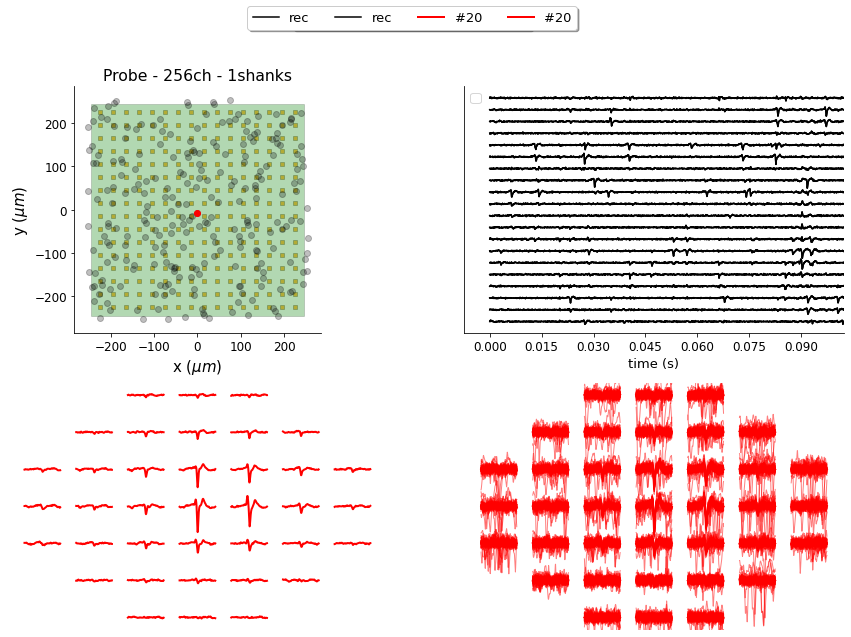

In [182]:
plot_figure_1(benchmarks[0])
plt.savefig('illustation_bis.pdf')

In [179]:
plt.savefig('illustation.pdf')

<Figure size 432x288 with 0 Axes>

In [6]:
from spikeinterface.sortingcomponents.benchmark.benchmark_peak_localization import BenchmarkPeakLocalization, plot_figure_1

In [7]:
from spikeinterface.sortingcomponents.benchmark.benchmark_peak_localization import plot_comparison_precision

In [8]:
benchmarks_ms = {}
waveforms = None
xaxis = [0.25, 0.5, 0.75, 1, 1.25, 1.5]
benchmarks_ms['xaxis'] = xaxis

for method in ['monopolar_triangulation', 'center_of_mass', 'grid_convolution']:
    for t_range in xaxis:
        if method == 'monopolar_triangulation':
            for feature in ['ptp', 'energy', 'peak_voltage']:
                title = f'Monopolar ({feature})'
                params = {'enforce_decrease': True, 'ms_before' : t_range, 'ms_after' : t_range, 'feature' : feature}
                bench = BenchmarkPeakLocalization(recording_f, gt_sorting, positions, job_kwargs=job_kwargs, title=title)
                if waveforms is not None:
                    bench.waveforms = waveforms    
                bench.run(method, params)
                waveforms = bench.waveforms
                if title in benchmarks_ms:
                    benchmarks_ms[title] += [bench]
                else:
                    benchmarks_ms[title] = [bench]
        elif method == 'center_of_mass':
            for feature in ['ptp', 'energy', 'peak_voltage']:
                params = {'ms_before' : t_range, 'ms_after' : t_range, 'feature' : feature}
                title = f'CoM ({feature})'
                bench = BenchmarkPeakLocalization(recording_f, gt_sorting, positions, job_kwargs=job_kwargs, title=title)
                if waveforms is not None:
                    bench.waveforms = waveforms    
                bench.run(method, params)
                waveforms = bench.waveforms
                if title in benchmarks_ms:
                    benchmarks_ms[title] += [bench]
                else:
                    benchmarks_ms[title] = [bench]
        elif method == 'grid_convolution':
            params = {'ms_before' : t_range, 'ms_after' : t_range}
            title = f'Grid'
            bench = BenchmarkPeakLocalization(recording_f, gt_sorting, positions, job_kwargs=job_kwargs, title=title)
            if waveforms is not None:
                bench.waveforms = waveforms    
            bench.run(method, params)
            waveforms = bench.waveforms
            if title in benchmarks_ms:
                benchmarks_ms[title] += [bench]
            else:
                benchmarks_ms[title] = [bench]



extract waveforms shared_memory with n_jobs = 20 and chunk_size = 9765


extract waveforms shared_memory:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation with n_jobs = 20 and chunk_size = 9765


localize peaks using monopolar_triangulation:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation with n_jobs = 20 and chunk_size = 9765


localize peaks using monopolar_triangulation:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation with n_jobs = 20 and chunk_size = 9765


localize peaks using monopolar_triangulation:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation with n_jobs = 20 and chunk_size = 9765


localize peaks using monopolar_triangulation:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation with n_jobs = 20 and chunk_size = 9765


localize peaks using monopolar_triangulation:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation with n_jobs = 20 and chunk_size = 9765


localize peaks using monopolar_triangulation:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation with n_jobs = 20 and chunk_size = 9765


localize peaks using monopolar_triangulation:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation with n_jobs = 20 and chunk_size = 9765


localize peaks using monopolar_triangulation:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation with n_jobs = 20 and chunk_size = 9765


localize peaks using monopolar_triangulation:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation with n_jobs = 20 and chunk_size = 9765


localize peaks using monopolar_triangulation:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation with n_jobs = 20 and chunk_size = 9765


localize peaks using monopolar_triangulation:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation with n_jobs = 20 and chunk_size = 9765


localize peaks using monopolar_triangulation:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation with n_jobs = 20 and chunk_size = 9765


localize peaks using monopolar_triangulation:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation with n_jobs = 20 and chunk_size = 9765


localize peaks using monopolar_triangulation:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation with n_jobs = 20 and chunk_size = 9765


localize peaks using monopolar_triangulation:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation with n_jobs = 20 and chunk_size = 9765


localize peaks using monopolar_triangulation:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation with n_jobs = 20 and chunk_size = 9765


localize peaks using monopolar_triangulation:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation with n_jobs = 20 and chunk_size = 9765


localize peaks using monopolar_triangulation:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using center_of_mass with n_jobs = 20 and chunk_size = 9765


localize peaks using center_of_mass:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using center_of_mass with n_jobs = 20 and chunk_size = 9765


localize peaks using center_of_mass:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using center_of_mass with n_jobs = 20 and chunk_size = 9765


localize peaks using center_of_mass:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using center_of_mass with n_jobs = 20 and chunk_size = 9765


localize peaks using center_of_mass:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using center_of_mass with n_jobs = 20 and chunk_size = 9765


localize peaks using center_of_mass:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using center_of_mass with n_jobs = 20 and chunk_size = 9765


localize peaks using center_of_mass:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using center_of_mass with n_jobs = 20 and chunk_size = 9765


localize peaks using center_of_mass:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using center_of_mass with n_jobs = 20 and chunk_size = 9765


localize peaks using center_of_mass:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using center_of_mass with n_jobs = 20 and chunk_size = 9765


localize peaks using center_of_mass:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using center_of_mass with n_jobs = 20 and chunk_size = 9765


localize peaks using center_of_mass:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using center_of_mass with n_jobs = 20 and chunk_size = 9765


localize peaks using center_of_mass:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using center_of_mass with n_jobs = 20 and chunk_size = 9765


localize peaks using center_of_mass:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using center_of_mass with n_jobs = 20 and chunk_size = 9765


localize peaks using center_of_mass:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using center_of_mass with n_jobs = 20 and chunk_size = 9765


localize peaks using center_of_mass:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using center_of_mass with n_jobs = 20 and chunk_size = 9765


localize peaks using center_of_mass:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using center_of_mass with n_jobs = 20 and chunk_size = 9765


localize peaks using center_of_mass:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using center_of_mass with n_jobs = 20 and chunk_size = 9765


localize peaks using center_of_mass:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using center_of_mass with n_jobs = 20 and chunk_size = 9765


localize peaks using center_of_mass:   0%|          | 0/33 [00:00<?, ?it/s]

peak_pipeline with n_jobs = 20 and chunk_size = 9765


peak_pipeline:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using grid_convolution with n_jobs = 20 and chunk_size = 9765


localize peaks using grid_convolution:   0%|          | 0/33 [00:00<?, ?it/s]

peak_pipeline with n_jobs = 20 and chunk_size = 9765


peak_pipeline:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using grid_convolution with n_jobs = 20 and chunk_size = 9765


localize peaks using grid_convolution:   0%|          | 0/33 [00:00<?, ?it/s]

peak_pipeline with n_jobs = 20 and chunk_size = 9765


peak_pipeline:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using grid_convolution with n_jobs = 20 and chunk_size = 9765


localize peaks using grid_convolution:   0%|          | 0/33 [00:00<?, ?it/s]

peak_pipeline with n_jobs = 20 and chunk_size = 9765


peak_pipeline:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using grid_convolution with n_jobs = 20 and chunk_size = 9765


localize peaks using grid_convolution:   0%|          | 0/33 [00:00<?, ?it/s]

peak_pipeline with n_jobs = 20 and chunk_size = 9765


peak_pipeline:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using grid_convolution with n_jobs = 20 and chunk_size = 9765


localize peaks using grid_convolution:   0%|          | 0/33 [00:00<?, ?it/s]

peak_pipeline with n_jobs = 20 and chunk_size = 9765


peak_pipeline:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using grid_convolution with n_jobs = 20 and chunk_size = 9765


localize peaks using grid_convolution:   0%|          | 0/33 [00:00<?, ?it/s]

In [ ]:
benchmarks_radius = {}
waveforms = None
xaxis = [25, 50, 75, 100, 125, 150]
benchmarks_radius['xaxis'] = xaxis 

for method in ['monopolar_triangulation', 'center_of_mass', 'grid_convolution']:
    for r_range in xaxis:
        if method == 'monopolar_triangulation':
            for feature in ['ptp', 'energy', 'peak_voltage']:
                title = f'Monopolar ({feature})'
                params = {'enforce_decrease': True, 'local_radius_um' : r_range, 'feature' : feature}
                bench = BenchmarkPeakLocalization(recording_f, gt_sorting, positions, job_kwargs=job_kwargs, title=title)
                if waveforms is not None:
                    bench.waveforms = waveforms    
                bench.run(method, params)
                waveforms = bench.waveforms
                if title in benchmarks_radius:
                    benchmarks_radius[title] += [bench]
                else:
                    benchmarks_radius[title] = [bench]
        elif method == 'center_of_mass':
            for feature in ['ptp', 'energy', 'peak_voltage']:
                params = {'local_radius_um' : r_range, 'feature' : feature}
                title = f'CoM ({feature})'
                bench = BenchmarkPeakLocalization(recording_f, gt_sorting, positions, job_kwargs=job_kwargs, title=title)
                if waveforms is not None:
                    bench.waveforms = waveforms    
                bench.run(method, params)
                waveforms = bench.waveforms
                if title in benchmarks_radius:
                    benchmarks_radius[title] += [bench]
                else:
                    benchmarks_radius[title] = [bench]
        elif method == 'grid_convolution':
            params = {'local_radius_um' : r_range}
            title = f'Grid'
            bench = BenchmarkPeakLocalization(recording_f, gt_sorting, positions, job_kwargs=job_kwargs, title=title)
            if waveforms is not None:
                bench.waveforms = waveforms    
            bench.run(method, params)
            waveforms = bench.waveforms
            if title in benchmarks_radius:
                benchmarks_radius[title] += [bench]
            else:
                benchmarks_radius[title] = [bench]
    

extract waveforms shared_memory with n_jobs = 20 and chunk_size = 9765


In [43]:
recordings = {}

xaxis = [100, 300, 500, 700, 900]

for cut_off in xaxis :
    recordings[cut_off] = si.bandpass_filter(recording, freq_min=cut_off)
    recordings[cut_off] = si.common_reference(recordings[cut_off])
    recordings[cut_off] = si.zscore(recordings[cut_off])

In [44]:
benchmarks_cutoff = {}

benchmarks_cutoff['xaxis'] = xaxis 

for cut_off in xaxis:
    waveforms = None
    for method in ['monopolar_triangulation', 'center_of_mass', 'grid_convolution']:
    
        if method == 'monopolar_triangulation':
            for feature in ['ptp', 'energy', 'peak_voltage']:
                title = f'Monopolar ({feature})'
                params = {'enforce_decrease': True, 'feature' : feature}
                bench = BenchmarkPeakLocalization(recordings[cut_off], gt_sorting, positions, job_kwargs=job_kwargs, title=title)
                if waveforms is not None:
                    bench.waveforms = waveforms    
                bench.run(method, params)
                waveforms = bench.waveforms
                if title in benchmarks_cutoff:
                    benchmarks_cutoff[title] += [bench]
                else:
                    benchmarks_cutoff[title] = [bench]
        elif method == 'center_of_mass':
            for feature in ['ptp', 'energy', 'peak_voltage']:
                title = f'CoM ({feature})'
                params = {'feature' : feature}
                bench = BenchmarkPeakLocalization(recordings[cut_off], gt_sorting, positions, job_kwargs=job_kwargs, title=title)
                if waveforms is not None:
                    bench.waveforms = waveforms    
                bench.run(method, params)
                waveforms = bench.waveforms
                if title in benchmarks_cutoff:
                    benchmarks_cutoff[title] += [bench]
                else:
                    benchmarks_cutoff[title] = [bench]
        elif method == 'grid_convolution':
            title = f'Grid'
            params = {}
            bench = BenchmarkPeakLocalization(recordings[cut_off], gt_sorting, positions, job_kwargs=job_kwargs, title=title)
            if waveforms is not None:
                bench.waveforms = waveforms    
            bench.run(method, params)
            waveforms = bench.waveforms
            if title in benchmarks_cutoff:
                benchmarks_cutoff[title] += [bench]
            else:
                benchmarks_cutoff[title] = [bench]

extract waveforms memmap with n_jobs = 72 and chunk_size = 9765


extract waveforms memmap:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation with n_jobs = 72 and chunk_size = 9765


localize peaks using monopolar_triangulation:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation with n_jobs = 72 and chunk_size = 9765


localize peaks using monopolar_triangulation:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation with n_jobs = 72 and chunk_size = 9765


localize peaks using monopolar_triangulation:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using center_of_mass with n_jobs = 72 and chunk_size = 9765


localize peaks using center_of_mass:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using center_of_mass with n_jobs = 72 and chunk_size = 9765


localize peaks using center_of_mass:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using center_of_mass with n_jobs = 72 and chunk_size = 9765


localize peaks using center_of_mass:   0%|          | 0/33 [00:00<?, ?it/s]

peak_pipeline with n_jobs = 72 and chunk_size = 9765


peak_pipeline:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using grid_convolution with n_jobs = 72 and chunk_size = 9765


localize peaks using grid_convolution:   0%|          | 0/33 [00:00<?, ?it/s]

extract waveforms memmap with n_jobs = 72 and chunk_size = 9765


extract waveforms memmap:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation with n_jobs = 72 and chunk_size = 9765


localize peaks using monopolar_triangulation:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation with n_jobs = 72 and chunk_size = 9765


localize peaks using monopolar_triangulation:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation with n_jobs = 72 and chunk_size = 9765


localize peaks using monopolar_triangulation:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using center_of_mass with n_jobs = 72 and chunk_size = 9765


localize peaks using center_of_mass:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using center_of_mass with n_jobs = 72 and chunk_size = 9765


localize peaks using center_of_mass:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using center_of_mass with n_jobs = 72 and chunk_size = 9765


localize peaks using center_of_mass:   0%|          | 0/33 [00:00<?, ?it/s]

peak_pipeline with n_jobs = 72 and chunk_size = 9765


peak_pipeline:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using grid_convolution with n_jobs = 72 and chunk_size = 9765


Exception ignored in: <function BenchmarkPeakLocalization.__del__ at 0x7f51214913f0>
Traceback (most recent call last):
  File "/media/cure/Secondary/pierre/softwares/spikeinterface/src/spikeinterface/sortingcomponents/benchmark/benchmark_peak_localization.py", line 46, in __del__
    shutil.rmtree(self.tmp_folder)
  File "/home/cure/anaconda3/envs/circus/lib/python3.10/shutil.py", line 714, in rmtree
    onerror(os.lstat, path, sys.exc_info())
  File "/home/cure/anaconda3/envs/circus/lib/python3.10/shutil.py", line 712, in rmtree
    orig_st = os.lstat(path)
FileNotFoundError: [Errno 2] No such file or directory: './2ZPWC7TQ'
Exception ignored in: <function BenchmarkPeakLocalization.__del__ at 0x7f51214913f0>
Traceback (most recent call last):
  File "/media/cure/Secondary/pierre/softwares/spikeinterface/src/spikeinterface/sortingcomponents/benchmark/benchmark_peak_localization.py", line 46, in __del__
    shutil.rmtree(self.tmp_folder)
  File "/home/cure/anaconda3/envs/circus/lib/pyt

localize peaks using grid_convolution:   0%|          | 0/33 [00:00<?, ?it/s]

extract waveforms memmap with n_jobs = 72 and chunk_size = 9765


extract waveforms memmap:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation with n_jobs = 72 and chunk_size = 9765


localize peaks using monopolar_triangulation:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation with n_jobs = 72 and chunk_size = 9765


localize peaks using monopolar_triangulation:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation with n_jobs = 72 and chunk_size = 9765


localize peaks using monopolar_triangulation:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using center_of_mass with n_jobs = 72 and chunk_size = 9765


localize peaks using center_of_mass:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using center_of_mass with n_jobs = 72 and chunk_size = 9765


localize peaks using center_of_mass:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using center_of_mass with n_jobs = 72 and chunk_size = 9765


localize peaks using center_of_mass:   0%|          | 0/33 [00:00<?, ?it/s]

peak_pipeline with n_jobs = 72 and chunk_size = 9765


peak_pipeline:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using grid_convolution with n_jobs = 72 and chunk_size = 9765


localize peaks using grid_convolution:   0%|          | 0/33 [00:00<?, ?it/s]

extract waveforms memmap with n_jobs = 72 and chunk_size = 9765


extract waveforms memmap:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation with n_jobs = 72 and chunk_size = 9765


localize peaks using monopolar_triangulation:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation with n_jobs = 72 and chunk_size = 9765


localize peaks using monopolar_triangulation:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation with n_jobs = 72 and chunk_size = 9765


localize peaks using monopolar_triangulation:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using center_of_mass with n_jobs = 72 and chunk_size = 9765


localize peaks using center_of_mass:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using center_of_mass with n_jobs = 72 and chunk_size = 9765


localize peaks using center_of_mass:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using center_of_mass with n_jobs = 72 and chunk_size = 9765


localize peaks using center_of_mass:   0%|          | 0/33 [00:00<?, ?it/s]

peak_pipeline with n_jobs = 72 and chunk_size = 9765


peak_pipeline:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using grid_convolution with n_jobs = 72 and chunk_size = 9765


localize peaks using grid_convolution:   0%|          | 0/33 [00:00<?, ?it/s]

extract waveforms memmap with n_jobs = 72 and chunk_size = 9765


extract waveforms memmap:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation with n_jobs = 72 and chunk_size = 9765


localize peaks using monopolar_triangulation:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation with n_jobs = 72 and chunk_size = 9765


localize peaks using monopolar_triangulation:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation with n_jobs = 72 and chunk_size = 9765


localize peaks using monopolar_triangulation:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using center_of_mass with n_jobs = 72 and chunk_size = 9765


localize peaks using center_of_mass:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using center_of_mass with n_jobs = 72 and chunk_size = 9765


localize peaks using center_of_mass:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using center_of_mass with n_jobs = 72 and chunk_size = 9765


localize peaks using center_of_mass:   0%|          | 0/33 [00:00<?, ?it/s]

peak_pipeline with n_jobs = 72 and chunk_size = 9765


peak_pipeline:   0%|          | 0/33 [00:00<?, ?it/s]

localize peaks using grid_convolution with n_jobs = 72 and chunk_size = 9765


localize peaks using grid_convolution:   0%|          | 0/33 [00:00<?, ?it/s]

In [16]:
from spikeinterface.sortingcomponents.benchmark.benchmark_tools import BenchmarkBase, _simpleaxis 
import pylab as plt
import matplotlib


def plot_comparison_precision(benchmarks, cmap='winter'):

    import pylab as plt
    fig, axes = plt.subplots(ncols=2, nrows=len(benchmarks), figsize=(15, 10), squeeze=False)
    
    for icount, benchmark in enumerate(benchmarks):
    
        vrange = np.array(list(benchmark.keys()))
        v_min = np.min(vrange)
        v_max = np.max(vrange)
        
        my_cmap = plt.get_cmap(cmap)
        cNorm  = matplotlib.colors.Normalize(vmin=v_min, vmax=v_max)
        scalarMap = plt.cm.ScalarMappable(norm=cNorm, cmap=my_cmap)
        
        for key, bench in benchmark.items():

            spikes = bench.spike_positions[0]
            units = bench.waveforms.sorting.unit_ids
            all_x = np.concatenate([spikes[unit_id]['x'] for unit_id in units])
            all_y = np.concatenate([spikes[unit_id]['y'] for unit_id in units])
            try:
                all_z = np.concatenate([spikes[unit_id]['z'] for unit_id in units])
            except Exception:
                all_z = np.zeros(len(all_x))
                
            gt_positions = bench.gt_positions
            real_x = np.concatenate([gt_positions[c, 0]*np.ones(len(spikes[i]['x'])) for c, i in enumerate(units)])
            real_y = np.concatenate([gt_positions[c, 1]*np.ones(len(spikes[i]['y'])) for c, i in enumerate(units)])
            try:
                real_z = np.concatenate([gt_positions[c, 2]*np.ones(len(spikes[i]['z'])) for c, i in enumerate(units)])
            except Exception:
                real_z = np.zeros(len(real_x))
                
            dx = np.abs(all_x - real_x)
            dy = np.abs(all_y - real_y)
            dz = np.abs(all_z - real_z)
            ax = axes[icount, 0]
            
            colorVal = scalarMap.to_rgba(key)
            
            ax.errorbar(np.arange(3), [dx.mean(), dy.mean(), dz.mean()], 
                        yerr=[dx.std(), dy.std(), dz.std()], label=bench.title, c=colorVal)
        ax.legend()
        ax.set_ylabel('error (um)')
        ax.set_xticks(np.arange(3), ['x', 'y', 'z'])
        _simpleaxis(ax)

        x_means = []
        x_stds = []
        for bench in benchmark.values():
            x_means += [np.mean(bench.medians_over_templates)]
            x_stds += [np.std(bench.medians_over_templates)]

        #ax.set_yticks([])
        #ax.set_ylim(ymin, ymax)

        ax = axes[icount, 1]
        _simpleaxis(ax)

        y_means = []
        y_stds = []
        colors = []
        for key, bench in benchmark.items():
            y_means += [np.mean(bench.mads_over_templates)]
            y_stds += [np.std(bench.mads_over_templates)]
            colors += [scalarMap.to_rgba(key)]

        ax.errorbar(x_means, y_means, xerr=x_stds, yerr=y_stds, fmt='.', c='0.5', alpha=0.5)
        ax.scatter(x_means, y_means, c=colors, s=200)

        ax.set_ylabel('error variances (um)')
        ax.set_xlabel('error means (um)')
      #ax.set_yticks([]
        ymin, ymax = ax.get_ylim()
        #ax.set_ylim(0, 25)
        ax.legend()

In [15]:
from spikeinterface.sortingcomponents.benchmark.benchmark_tools import BenchmarkBase, _simpleaxis 
import pylab as plt
import matplotlib

def plot_comparison_precision_2(benchmarks, colors=None):

    import pylab as plt
    fig, axes = plt.subplots(nrows=3, ncols=len(benchmarks) + 1, figsize=(15, 7), squeeze=False)
    
    to_explore = list(benchmarks[0].keys())
    to_explore.remove('xaxis')
    
    for title in to_explore:
        
        
        if title.find('Monopolar') > -1:
            jcount = 1
        elif title.find('CoM') > -1:
            jcount = 0
        elif title.find('Grid') > -1:
            jcount = 2
    
        for icount, benchmark in enumerate(benchmarks):

            bench = benchmark[title]
            
            #vrange = np.array(list(bench.keys()))
            #v_min = np.min(vrange)
            #v_max = np.max(vrange)

            #my_cmap = plt.get_cmap(cmaps[jcount])
            #cNorm  = matplotlib.colors.Normalize(vmin=v_min, vmax=v_max)
            #scalarMap = plt.cm.ScalarMappable(norm=cNorm, cmap=my_cmap)

            if icount == len(benchmarks) - 1:
                b = bench[0]

                spikes = b.spike_positions[0]
                units = b.waveforms.sorting.unit_ids
                all_x = np.concatenate([spikes[unit_id]['x'] for unit_id in units])
                all_y = np.concatenate([spikes[unit_id]['y'] for unit_id in units])
                try:
                    all_z = np.concatenate([spikes[unit_id]['z'] for unit_id in units])
                except Exception:
                    all_z = np.nan * np.zeros(len(all_x))

                gt_positions = b.gt_positions
                real_x = np.concatenate([gt_positions[c, 0]*np.ones(len(spikes[i]['x'])) for c, i in enumerate(units)])
                real_y = np.concatenate([gt_positions[c, 1]*np.ones(len(spikes[i]['y'])) for c, i in enumerate(units)])
                try:
                    real_z = np.concatenate([gt_positions[c, 2]*np.ones(len(spikes[i]['z'])) for c, i in enumerate(units)])
                except Exception:
                    real_z = np.nan * np.zeros(len(real_x))

                dx = np.abs(all_x - real_x)
                dy = np.abs(all_y - real_y)
                dz = np.abs(all_z - real_z)
                ax = axes[jcount, icount+1]
                
                x_means = np.array([np.nanmean(dx), np.nanmean(dy), np.nanmean(dz)])
                y_means = np.array([np.nanstd(dx), np.nanstd(dy), np.nanstd(dz)])
                
                ax.plot(np.arange(3), x_means, c=colors[title], lw=2)
                ax.fill_between(np.arange(len(x_means)), x_means-y_means,x_means+y_means,
                            color=colors[title], alpha=0.05)
                _simpleaxis(ax)
                
                ax.set_ylabel('error (um)')
                #if jcount == 0:
                ax.set_xticks(np.arange(3), ['x', 'y', 'z'])
                ax.set_ylim(0, 45)
            
            ax = axes[jcount, icount]
            
            _simpleaxis(ax)

            x_means = []
            y_means = []
            y_stds = []
            labels = []
            
            for b in bench:
                x_means += [np.mean(b.medians_over_templates)]
                #x_stds += [np.std(b.medians_over_templates)]
                y_means += [np.mean(b.mads_over_templates)]
                #y_stds += [np.std(b.mads_over_templates)]
                #colors += [scalarMap.to_rgba(key)]
                #label = b.title.replace('Mononopolar', '')
                #label = label.replace('CoM (ptp)', '')
                #label = label.replace('Grid', '')
                #label = label.replace('[', '')
                #label = label.replace(']', '')
                #labels += [label]
                #title = b.title
            xaxis = benchmark['xaxis']
                #ax.scatter(x_means, y_means, c=colors, label=label, s=200, edgecolor='k')
            
            x_means = np.array(x_means)
            y_means = np.array(y_means)
            ax.plot(xaxis, x_means, color=colors[title], lw=2, label=title)
            ax.fill_between(xaxis, x_means-y_means,x_means+y_means,
                            color=colors[title], alpha=0.05)
                
            #ax.errorbar(x_means, y_means, xerr=x_stds, yerr=y_stds, fmt='.', c='0.5', alpha=0.5)
                
    
            #ax.legend(loc='lower right')
            
            if icount == 0:
                ax.set_ylabel('error medians (um)')
            else:
                ax.set_yticks([])
            
            if jcount == 2:
                if icount == 0:
                    ax.set_xlabel('Time (ms)')
                elif icount == 1:
                    ax.set_xlabel('Radius (um)')
                elif icount == 2:
                    ax.set_xlabel('Cutoff (Hz)')
            else:
                ax.set_xticks([])
                #ax.set_xlim(7, 9)
            #    ax.set_xticks([])
            #else:
            #    ax.set_xticks(np.arange(len(labels)), labels, rotation=45)
                #ax.set_xlim(12, 14)
            
            #ymin, ymax = ax.get_ylim()
            
            ax.set_ylim(5, 35)
            #else:
            #    ax.set_ylim(0, 2)
                #ax.set_xlim(5, 20)
            
            #ax.set_title(method)
        axes[jcount, 0].legend()

AttributeError: 'list' object has no attribute 'keys'

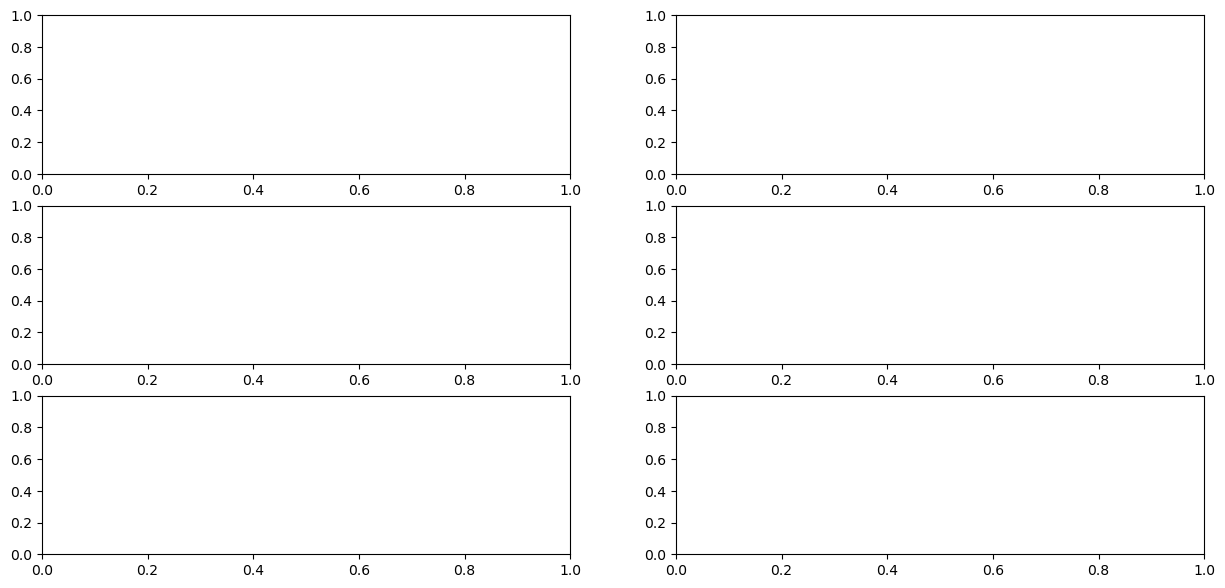

In [18]:
plot_comparison_precision_2([benchmarks], colors=colors)
plt.tight_layout()
#plt.savefig('influence.pdf')

In [134]:
benchmarks_cutoff['Monopolar (peak_voltage)'] = benchmarks_cutoff.pop('Mononopolar (peak_voltage)')

In [131]:
benchmarks_cutoff.keys()

dict_keys(['xaxis', 'Mononopolar (ptp)', 'Mononopolar (energy)', 'Mononopolar (peak_voltage)', 'CoM (ptp)', 'CoM (energy)', 'CoM (peak_voltage)', 'Grid'])

In [82]:
tmp[0]

'Mononopolar (ptp)'